## Loading Data and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split

## Reusable Functions

In [ ]:
def check_missing_values(df):
  """
  Checks for missing values in a given dataframe and returns a boolean indicating whether any missing values are present.

  Parameters:
  df (pandas.DataFrame): The dataframe to check for missing values.

  Returns:
  bool: True if there are missing values in the dataframe, False otherwise.
  """
  # count the number of missing values in each column
  missing_values = df.isnull().sum()

  # display the number of missing values in each column
  print(missing_values)

In [ ]:
def check_outliers(df, attributes):
  """
  Checks for outliers in each column of a given dataframe and creates a box plot to visualize the distribution of the data and the outliers.

  Parameters:
  df (pandas.DataFrame): The dataframe to check for outliers.
  attributes (list): list of attributes to check the outliers for

  Returns:
  None
  """
  # Calculate the interquartile range (IQR) for each column
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1

  # Identify potential outliers for each column
  potential_outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))

  # Create a box plot to visualize the distribution of the data and the outliers for each column
  for col in df.columns:
    if col in attributes:
      sns.boxplot(x=df[col])
      plt.title(f"{col}")
      plt.show()

In [ ]:
def check_collinearity(df):
  """
  Checks for collinearity in a given dataframe and creates a heatmap to visualize the correlation matrix.
  
  Parameters:
  df (pandas.DataFrame): The dataframe to check for collinearity.
  
  Returns:
  None
  """
  # Compute the correlation matrix
  corr = df.corr()

  # Create a heatmap to visualize the correlation matrix
  sns.heatmap(corr, cmap=sns.color_palette("YlOrBr", as_cmap=True))
  plt.title('Correlation Matrix Heatmap')
  plt.show()

In [ ]:
def check_multimodality(df, attributes):
  """
  Checks for multimodality in the specified attributes of a given dataframe and creates a histogram plot to visualize the distribution of the data.

  Parameters:
  df (pandas.DataFrame): The dataframe to check for multimodality.
  attributes (list of str): The names of the attributes to check for multimodality.

  Returns:
  None
  """
  for attribute in attributes:
    sns.histplot(data=df[attribute], bins='auto', kde=True)
    plt.title(f"{attribute} Distribution")
    plt.xlabel(attribute)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
def check_skewness_and_kurtosis(df, columns):
  """
  Checks the skewness and kurtosis of specific columns in a given pandas DataFrame.
  
  Parameters:
  df (pandas.DataFrame): The DataFrame to check for skewness and kurtosis.
  columns (list): A list of column names to check.
  
  Returns:
  None
  """
  # Loop over the columns and calculate skewness and kurtosis for each
  for col in columns:
    skewness = df[col].skew()
    kurt = df[col].kurt()
    
    # Print the results
    print(f"Column '{col}': Skewness = {skewness:.2f}, Kurtosis = {kurt:.2f}")

In [ ]:
def remove_duplicates(df):
  # count the number of duplicate rows in the dataframe
  num_duplicates = df.duplicated().sum()

  # remove duplicate rows from the dataframe
  df_clean = df.drop_duplicates()

  # print the number of duplicate rows removed
  print(f"Removed {num_duplicates} duplicate rows")

  return df_clean

In [ ]:
from sklearn.impute import KNNImputer


def impute_missing_values(df, columns):
  """
  Imputes missing values in specified columns of a dataframe using appropriate strategies.

  Parameters:
  df (pandas.DataFrame): The dataframe to impute missing values in.
  columns (list of str): The names of the columns to impute missing values in.

  Returns:
  pandas.DataFrame: The dataframe with imputed missing values.
  """
  df_filled = df.copy()
  for column in columns:
    if df_filled[column].dtype == 'object':
      # For string type columns, use the most frequent strategy
      df_filled[column].fillna(df_filled[column].mode()[0], inplace=True)
    elif np.issubdtype(df_filled[column].dtype, np.datetime64):
      # For date type columns, use a custom strategy
      df_filled[column].fillna(pd.Timestamp('2023-01-01'), inplace=True)
    else:
      # For numeric type columns, use KNNImputer
      imputer = KNNImputer()
      df_filled[column] = imputer.fit_transform(df_filled[[column]])

  return df_filled

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pca_df(df, components):
  """
  Runs the PCA algorithm on the input dataframe and visualises the features
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    n_components (int): Number of components to extract
      
  Returns:
    pca (sklearn.decomposition.PCA): PCA object fitted to the data
    pca_components (pandas.DataFrame): Dataframe containing the principal components
  """
  # Extract the features from the input dataframe
  features = df.values
  
  # Standardize the features
  standardized_features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
  
  # Run the PCA algorithm
  pca = PCA(n_components=components)
  pca.fit(standardized_features)
  
  # Plot the feature loadings for the first two principal components
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.scatter(pca.components_[0], pca.components_[1])
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  
  # Label the features
  for i, feature in enumerate(df.columns):
    ax.annotate(feature, (pca.components_[0][i], pca.components_[1][i]))
    ax.arrow(0, 0, pca.components_[0][i], pca.components_[1][i], head_width=0.01, head_length=0.1, fc='k', ec='k')
  
  plt.show()
  
  # Create dataframe containing the principal components
  pca_components = pd.DataFrame(pca.fit_transform(df), columns=['PC' + str(i+1) for i in range(components)])
  
  return pca, pca_components


In [ ]:
def scree_plot(pca_components):
  """
  Creates a scree plot for the principal components of a PCA analysis.
  
  Args:
    pca_components (pandas.DataFrame): Principal components of a PCA analysis
      
  Returns:
    None
  """
  # Calculate the variance explained by each principal component
  var = pca_components.var() / sum(pca_components.var())
  var_cumulative = np.cumsum(var)
  
  # Plot the variance explained by each principal component
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(np.arange(1, len(var)+1), var, 'o-')
  ax.set_xlabel('Principal Component')
  ax.set_ylabel('Variance Explained (%)')
  ax.set_title('Scree Plot')
  
  # Plot the cumulative variance explained by the principal components
  ax2 = ax.twinx()
  ax2.plot(np.arange(1, len(var)+1), var_cumulative, 'o-', color='orange')
  ax2.set_ylabel('Cumulative Variance Explained (%)')
  
  plt.show()


In [ ]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

def boruta_df(df, target_col):
  """
  Runs the Boruta feature selection algorithm on the input dataframe
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    target_col (str): Name of the target column in the dataframe
  
  Returns:
    pandas.DataFrame: Dataframe with the selected features
  """
  # Separate the input features from the target variable
  X = df.drop(target_col, axis=1).values
  y = df[target_col].values
  
  # Initialize a random forest classifier
  rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
  
  # Run the Boruta feature selection algorithm
  boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
  boruta.fit(X, y)
  
  # Get the selected features from the Boruta output
  selected_features = df.columns[:-1][boruta.support_]
  
  # Return a dataframe with the selected features
  return df[selected_features + [target_col]]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def feature_importance_df(df, target_col):
  """
  Runs the Random Forest feature importance algorithm on the input dataframe
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    target_col (str): Name of the target column in the dataframe
  
  Returns:
    pandas.DataFrame: Dataframe with the selected features
  """
  
  # Separate the input features from the target variable
  X = df.drop(target_col, axis=1).values
  y = df[target_col].values
  
  # Initialize a random forest regressor
  rf = RandomForestRegressor(n_jobs=-1, random_state=1)
  
  # Fit the random forest regressor to the data
  rf.fit(X, y)
  
  # Get the feature importance scores from the random forest regressor
  importance_scores = rf.feature_importances_
  
  # Sort the features by their importance scores in descending order
  sorted_features = df.drop(target_col, axis=1).columns[np.argsort(importance_scores)[::-1]]
  
  # Return a dataframe with the selected features
  return df[sorted_features.tolist() + [target_col]], importance_scores

In [ ]:
#define metrics function for us to calculate everything at the same place
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def perf_metrics(y_test, y_pred, n, p, name):
  MSE = mean_squared_error(y_test, y_pred)
  print(name, "Mean Squared Error:", f'{MSE:.2f}')
  MAE = mean_absolute_error(y_test, y_pred)
  print(name, "Mean Absolute Error:", f'{MAE:.2f}')
  R2 = r2_score(y_test, y_pred)
  print(name, "R-Squared Value:", f'{R2:.2f}')
  A_R2 = 1 - ((1 - R2) * (n - 1)) / (n - p - 1)
  print(name, "Adjusted R-Squared Value:", f'{A_R2:.2f}','\n')

In [ ]:
from sklearn.linear_model import LinearRegression

def linear_regression(df, target_col):
  """
  Runs the Linear Regression algorithm on the input dataframe
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    target_col (str): Name of the target column in the dataframe
  
  Returns:
    None
  """
  
  # Separate the input features from the target variable
  X = df.drop(target_col, axis=1).values
  y = df[target_col].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7357)

  n = X_test.shape[0]      # number of samples in test set
  p = X_test.shape[1]      # number of predictor variables

  #Linear regression
  # Train the model
  lr1 = LinearRegression()
  lr1.fit(X_train, y_train)

  # Make predictions on the test set
  LR_y_pred = lr1.predict(X_test)
  LR_y_train = lr1.predict(X_train)

  perf_metrics(y_test=y_train, y_pred=LR_y_train, n = X_train.shape[0], p = X_train.shape[1], name="Linear Regressor (Train)")
  perf_metrics(y_test=y_test, y_pred=LR_y_pred, n = n, p = p, name="Linear Regressor (Test)")

In [ ]:
#Gradient Boosting regression
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boosting_regression(df, target_col):
  """
  Runs the Linear Regression algorithm on the input dataframe
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    target_col (str): Name of the target column in the dataframe
  
  Returns:
    None
  """
  
  # Separate the input features from the target variable
  X = df.drop(target_col, axis=1).values
  y = df[target_col].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7357)

  n = X_test.shape[0]      # number of samples in test set
  p = X_test.shape[1]      # number of predictor variables

  # Train the model
  gb1 = GradientBoostingRegressor()
  gb1.fit(X_train, y_train)

  # Make predictions on the test set
  GB_y_pred = gb1.predict(X_test)

  perf_metrics(y_test=y_test, y_pred=GB_y_pred, n = n, p = p, name="Gradient Boosting Regressor")

In [ ]:
#XG Boost regression
from xgboost import XGBRegressor

def xgboost_regression(df, target_col):
  """
  Runs the Linear Regression algorithm on the input dataframe
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    target_col (str): Name of the target column in the dataframe
  
  Returns:
    None
  """
  
  # Separate the input features from the target variable
  X = df.drop(target_col, axis=1).values
  y = df[target_col].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7357)

  n = X_test.shape[0]      # number of samples in test set
  p = X_test.shape[1]      # number of predictor variables

  # Train the model
  xgb1 = XGBRegressor()
  xgb1.fit(X_train, y_train)

  # Make predictions on the test set
  XGB_y_pred = xgb1.predict(X_test)

  perf_metrics(y_test=y_test, y_pred=XGB_y_pred, n = n, p = p, name="XGBoost Regressor")

In [ ]:
#Support Vector regression
from sklearn.svm import SVR

def support_vector_regression(df, target_col):
  """
  Runs the Linear Regression algorithm on the input dataframe
  
  Args:
    df (pandas.DataFrame): Input dataframe with features
    target_col (str): Name of the target column in the dataframe
  
  Returns:
    None
  """
  
  # Separate the input features from the target variable
  X = df.drop(target_col, axis=1).values
  y = df[target_col].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7357)

  n = X_test.shape[0]      # number of samples in test set
  p = X_test.shape[1]      # number of predictor variables

  # Train the model with the radial kernel
  sv1 = SVR(kernel='linear')
  sv1.fit(X_train, y_train)

  # Make predictions on the test set
  SV_y_pred = sv1.predict(X_test)

  perf_metrics(y_test=y_test, y_pred=SV_y_pred, n = n, p = p, name="Support Vector Regressor")

## Load Data

In [ ]:
#Load Data
engagement = pd.read_csv('/content/drive/MyDrive/Data Driven Decision Making/Data/User engagement for users signed up since 010122.csv')
views = pd.read_csv('/content/drive/MyDrive/Data Driven Decision Making/Data/Snippet Views.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Data Driven Decision Making/Data/Snippet Ratings.csv')
snippets = pd.read_csv('/content/drive/MyDrive/Data Driven Decision Making/Data/Snippet Ratings (1).csv')

In [ ]:
engagement.head()

,user_id,user_created_at,bought_hero,signed_up,welcome_video,intake,wol,daily_assessment,started_lesson,download_worksheet,...,posted_community,completed_lesson,insert_date,id,age,gender,primary_problem,last_ahoy_visit,days_engaged,elapsed_days
0,1773,2022-02-19,NaN,1,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,1.0,2023-03-30,39570,42.0,Male,Alcohol,2022-10-01,22.0,224.0
1,1674,2022-02-07,NaN,1,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,2023-03-30,39571,36.0,Male,Alcohol,2022-02-07,1.0,0.0
2,1641,2022-02-04,NaN,1,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,2023-03-30,39586,43.0,Male,Alcohol,2022-02-04,1.0,0.0
3,1711,2022-02-12,NaN,1,NaN,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,2023-03-30,39590,38.0,Female,Drugs,2022-02-15,3.0,3.0
4,2961,2023-03-29,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2023-03-30,39594,NaN,NaN,Drugs,2023-03-30,3.0,1.0


In [ ]:
views.head()

,user_id,description,created_at
0,2497,"Scarcity vs abundance, having more trust than ...",2022-09-05 13:32:47.684184
1,2497,Understand your partner's stories to see how t...,2022-09-05 13:32:50.132694
2,2484,Adi talks about changing your habits and the i...,2022-09-05 14:22:55.812377
3,185,"Scarcity vs abundance, having more trust than ...",2022-09-05 21:55:57.762669
4,2493,Stop following other people's ideas of what it...,2022-09-06 02:16:50.440163


In [ ]:
ratings.head()

,rating,user_id,description,created_at
0,5,542,Finding the time to do for your relationships,2022-02-17 23:51:21.377631
1,4,11,Bringing you out of your comfort zone due to n...,2022-01-28 14:57:01.760169
2,5,743,Gauging social awareness amongst others to rea...,2022-01-28 15:43:19.412111
3,5,1602,Learning about control in our lives.,2022-01-29 03:11:38.980091
4,5,1602,Speaking sincerely about your actions that dea...,2022-01-29 03:21:36.62969


In [ ]:
snippets.head()

,description,rating,length_seconds,created_at
0,Accepting criticism and being open to listen t...,5,123.0,2022-07-27 22:18:54.790133
1,Accept the regularities of life instead of bei...,5,123.0,2022-08-28 16:47:23.626192
2,"Acknowledge the pain, but still showing gratitude",5,118.0,2022-07-11 03:08:02.677464
3,A deep dive into shame.\r\n,5,571.0,2022-04-02 13:31:36.037417
4,A different take on the glass half empty saying.,5,492.0,2022-03-09 10:09:34.3905


## Identifying Issues

### Engagement

In [ ]:
engagement.describe()

,user_id,bought_hero,signed_up,welcome_video,intake,wol,daily_assessment,started_lesson,download_worksheet,upload_worksheet,...,rated_lesson_1,finished_module_1,logged_into_group,created_community_acct,posted_community,completed_lesson,id,age,days_engaged,elapsed_days
count,1557.000000,202.0,1557.0,0.0,1556.0,1537.0,368.0,373.0,0.0,121.0,...,137.0,53.0,0.0,159.0,0.0,220.0,1557.000000,1531.000000,1530.000000,1530.000000
mean,1920.725755,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,40756.233141,41.577400,7.375163,21.952941
std,537.545054,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,794.416589,11.921792,30.076952,62.513332
min,1027.000000,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,39535.000000,17.000000,1.000000,-1.000000
25%,1458.000000,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,40061.000000,33.000000,1.000000,0.000000
50%,1861.000000,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,40626.000000,40.000000,1.000000,0.000000
75%,2392.000000,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,41635.000000,49.000000,2.000000,3.000000
max,2965.000000,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,NaN,1.0,NaN,1.0,42031.000000,90.000000,882.000000,440.000000


In [ ]:
check_missing_values(engagement)

user_id                      0
user_created_at              0
bought_hero               1355
signed_up                    0
welcome_video             1557
intake                       1
wol                         20
daily_assessment          1189
started_lesson            1184
download_worksheet        1557
upload_worksheet          1436
completed_worksheet       1557
rated_lesson_1            1420
finished_module_1         1504
logged_into_group         1557
created_community_acct    1398
posted_community          1557
completed_lesson          1337
insert_date                  0
id                           0
age                         26
gender                      23
primary_problem             70
last_ahoy_visit             27
days_engaged                27
elapsed_days                27
dtype: int64


In [ ]:
engagement.bought_hero.fillna(0, inplace=True)
engagement.signed_up.fillna(0, inplace=True)
engagement.welcome_video.fillna(0, inplace=True)
engagement.intake.fillna(0, inplace=True)
engagement.wol.fillna(0, inplace=True)
engagement.daily_assessment.fillna(0, inplace=True)
engagement.started_lesson.fillna(0, inplace=True)
engagement.bought_hero.fillna(0, inplace=True)
engagement.upload_worksheet.fillna(0, inplace=True)
engagement.rated_lesson_1.fillna(0, inplace=True)
engagement.finished_module_1.fillna(0, inplace=True)
engagement.created_community_acct.fillna(0, inplace=True)
engagement.completed_lesson.fillna(0, inplace=True)

In [ ]:
engagement = engagement.drop(columns = ['download_worksheet','completed_worksheet','logged_into_group','posted_community', 'id', 'insert_date', 'welcome_video', 'signed_up'])

In [ ]:
check_missing_values(engagement)

user_id                    0
user_created_at            0
bought_hero                0
intake                     0
wol                        0
daily_assessment           0
started_lesson             0
upload_worksheet           0
rated_lesson_1             0
finished_module_1          0
created_community_acct     0
completed_lesson           0
age                       26
gender                    23
primary_problem           70
last_ahoy_visit           27
days_engaged              27
elapsed_days              27
dtype: int64


<ipython-input-4-c96723bd3eec>:13: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-4-c96723bd3eec>:14: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
<ipython-input-4-c96723bd3eec>:18: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  potential_outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))


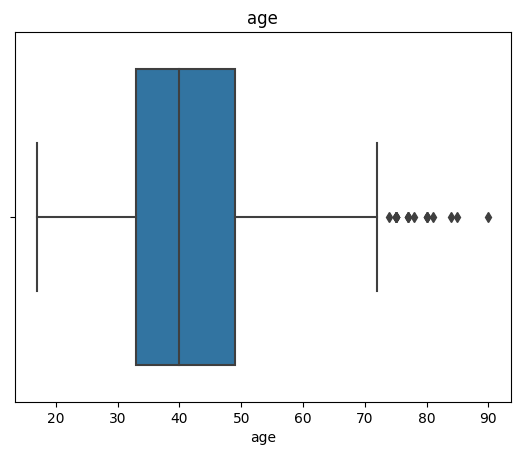

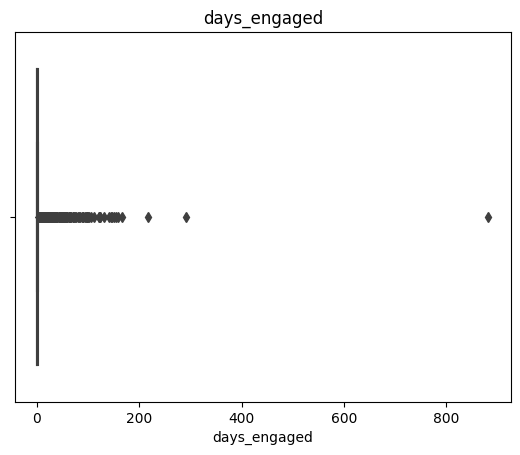

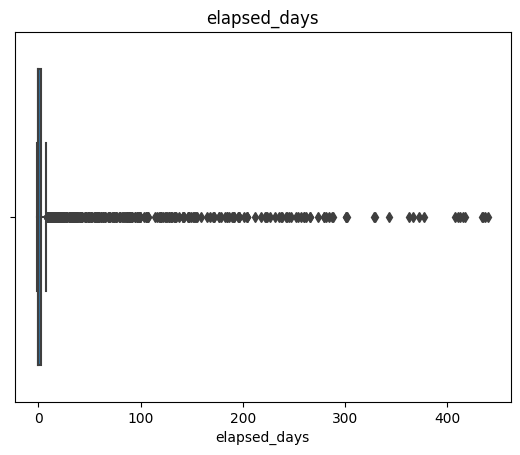

In [ ]:
check_outliers(engagement, ['age', 'days_engaged','elapsed_days'])

<ipython-input-5-b1d494918b05>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


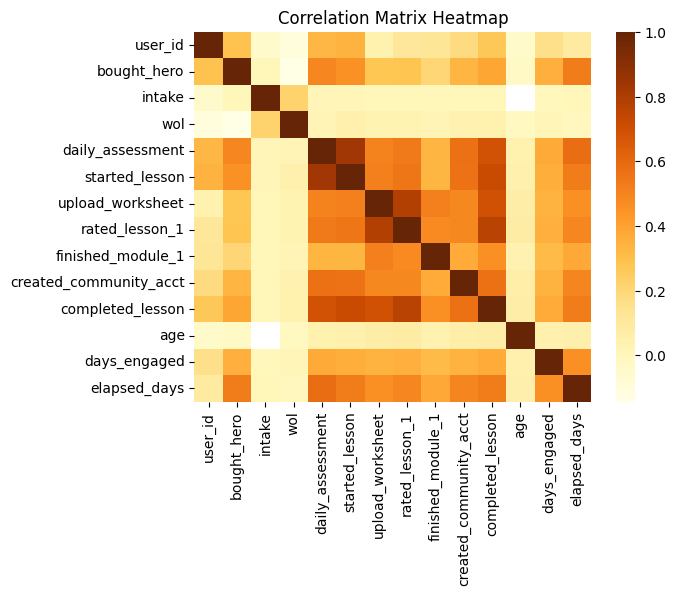

In [ ]:
check_collinearity(engagement)

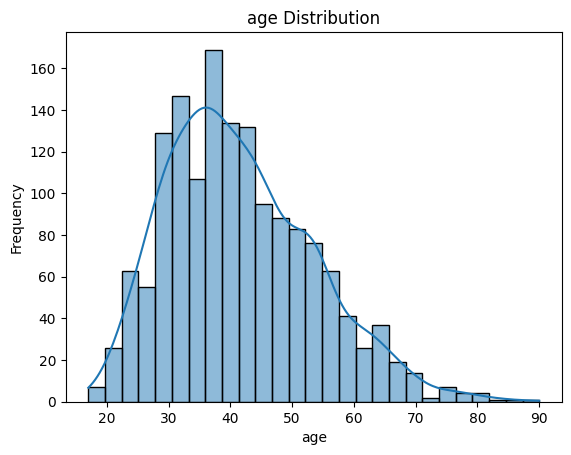

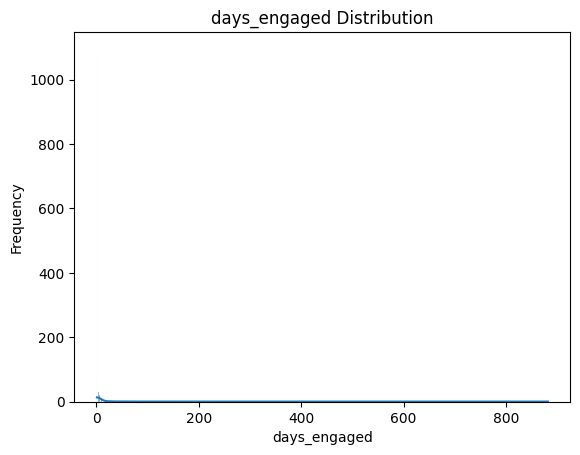

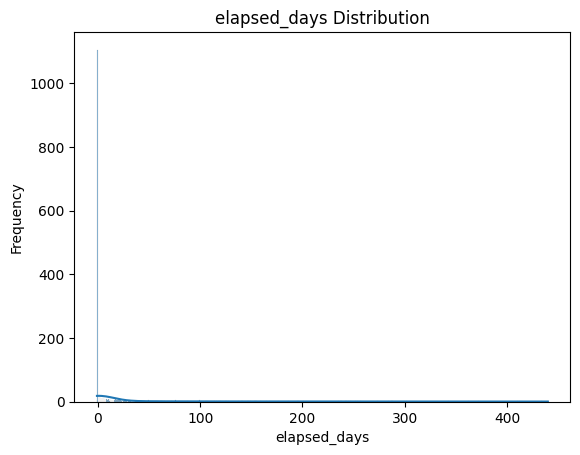

In [ ]:
check_multimodality(engagement, ['age', 'days_engaged','elapsed_days'])

In [ ]:
check_skewness_and_kurtosis(engagement, ['age', 'days_engaged','elapsed_days'])

Column 'age': Skewness = 0.63, Kurtosis = 0.17
Column 'days_engaged': Skewness = 17.93, Kurtosis = 477.40
Column 'elapsed_days': Skewness = 3.85, Kurtosis = 16.35


In [ ]:
remove_duplicates(engagement)

Removed 0 duplicate rows


,user_id,user_created_at,bought_hero,intake,wol,daily_assessment,started_lesson,upload_worksheet,rated_lesson_1,finished_module_1,created_community_acct,completed_lesson,age,gender,primary_problem,last_ahoy_visit,days_engaged,elapsed_days
0,1773,2022-02-19,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,42.0,Male,Alcohol,2022-10-01,22.0,224.0
1,1674,2022-02-07,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,Male,Alcohol,2022-02-07,1.0,0.0
2,1641,2022-02-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,Male,Alcohol,2022-02-04,1.0,0.0
3,1711,2022-02-12,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,38.0,Female,Drugs,2022-02-15,3.0,3.0
4,2961,2023-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Drugs,2023-03-30,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,1624,2022-02-01,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,Male,Alcohol,2022-02-01,1.0,0.0
1553,1885,2022-03-08,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,Female,Alcohol,2022-03-08,1.0,0.0
1554,1618,2022-01-31,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,Female,Alcohol,2022-02-10,4.0,10.0
1555,1615,2022-01-30,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,Male,Drugs,2022-02-07,2.0,8.0


### Ratings

In [ ]:
ratings.describe()

,rating,user_id
count,453.000000,453.000000
mean,4.523179,1635.679912
std,0.910857,876.530717
min,1.000000,11.000000
25%,4.000000,843.000000
50%,5.000000,2026.000000
75%,5.000000,2342.000000
max,5.000000,2934.000000


In [ ]:
check_missing_values(ratings)

rating         0
user_id        0
description    0
created_at     0
dtype: int64


<ipython-input-4-c96723bd3eec>:13: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-4-c96723bd3eec>:14: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
<ipython-input-4-c96723bd3eec>:18: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  potential_outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))


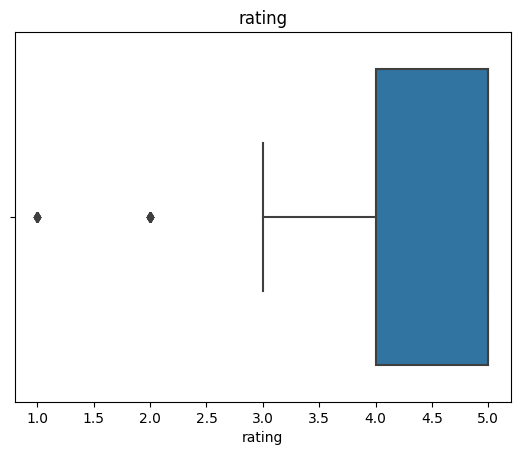

In [ ]:
check_outliers(ratings, ['rating'])

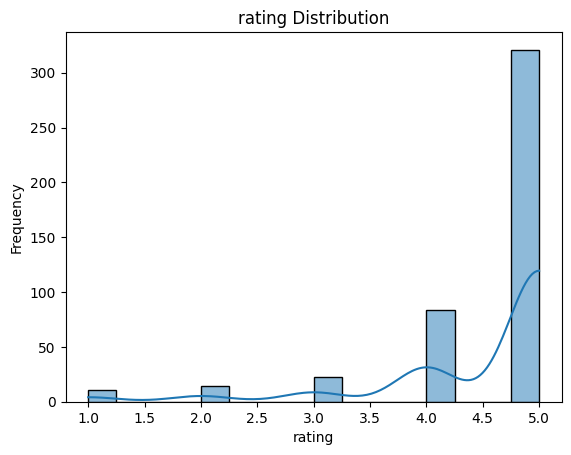

In [ ]:
check_multimodality(ratings, ['rating'])

In [ ]:
check_skewness_and_kurtosis(ratings, ['rating'])

Column 'rating': Skewness = -2.25, Kurtosis = 4.83


In [ ]:
remove_duplicates(ratings)

Removed 0 duplicate rows


,rating,user_id,description,created_at
0,5,542,Finding the time to do for your relationships,2022-02-17 23:51:21.377631
1,4,11,Bringing you out of your comfort zone due to n...,2022-01-28 14:57:01.760169
2,5,743,Gauging social awareness amongst others to rea...,2022-01-28 15:43:19.412111
3,5,1602,Learning about control in our lives.,2022-01-29 03:11:38.980091
4,5,1602,Speaking sincerely about your actions that dea...,2022-01-29 03:21:36.62969
...,...,...,...,...
448,5,2929,Knowing what were bad at but also knowing that...,2023-03-11 12:19:04.178711
449,5,2934,Examples of bringing down anger,2023-03-14 22:47:22.446367
450,2,2860,How does your shame fuel your beliefs? Coach J...,2023-03-17 23:51:39.672667
451,5,2934,How does your shame fuel your beliefs? Coach J...,2023-03-24 03:55:34.966707


### Views

In [ ]:
views.describe()

,user_id
count,2641.000000
mean,1956.164710
std,1053.698764
min,11.000000
25%,1137.000000
50%,2513.000000
75%,2741.000000
max,2935.000000


In [ ]:
check_missing_values(views)

user_id        0
description    0
created_at     0
dtype: int64


In [ ]:
remove_duplicates(views)

Removed 0 duplicate rows


,user_id,description,created_at
0,2497,"Scarcity vs abundance, having more trust than ...",2022-09-05 13:32:47.684184
1,2497,Understand your partner's stories to see how t...,2022-09-05 13:32:50.132694
2,2484,Adi talks about changing your habits and the i...,2022-09-05 14:22:55.812377
3,185,"Scarcity vs abundance, having more trust than ...",2022-09-05 21:55:57.762669
4,2493,Stop following other people's ideas of what it...,2022-09-06 02:16:50.440163
...,...,...,...
2636,2435,Selecting a purpose that feels right and knowi...,2023-03-25 04:47:12.406327
2637,2929,Handling being alone.,2023-03-25 09:48:14.926053
2638,49,Creating a GOTE sheet to strive,2023-03-25 13:54:06.551186
2639,2237,Analyzing how trauma has affected everybody an...,2023-03-25 17:58:02.121698


### Snippets

In [ ]:
snippets.describe()

,rating,length_seconds
count,435.000000,417.000000
mean,4.531034,215.419664
std,0.893307,167.944570
min,1.000000,28.000000
25%,4.000000,100.000000
50%,5.000000,158.000000
75%,5.000000,281.000000
max,5.000000,1044.000000


In [ ]:
check_missing_values(snippets)

description        0
rating             0
length_seconds    18
created_at         0
dtype: int64


<ipython-input-4-c96723bd3eec>:13: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-4-c96723bd3eec>:14: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
<ipython-input-4-c96723bd3eec>:18: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  potential_outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))


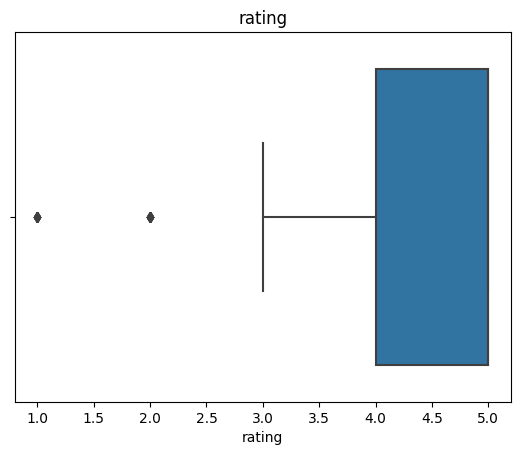

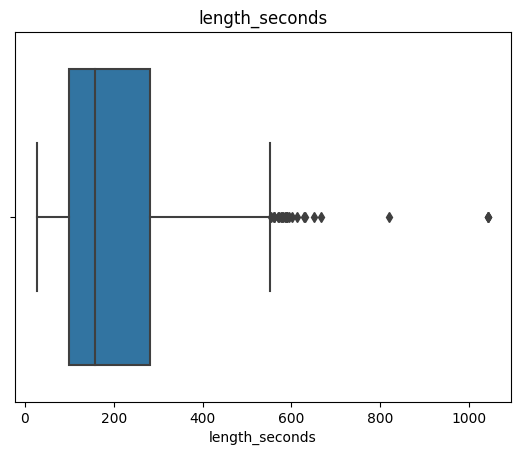

In [ ]:
check_outliers(snippets, ['rating', 'length_seconds'])

<ipython-input-5-b1d494918b05>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


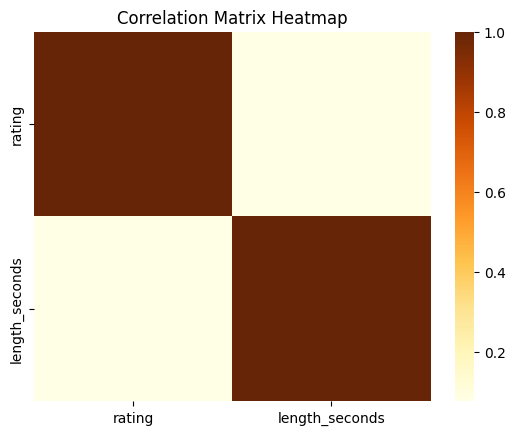

In [ ]:
check_collinearity(snippets)

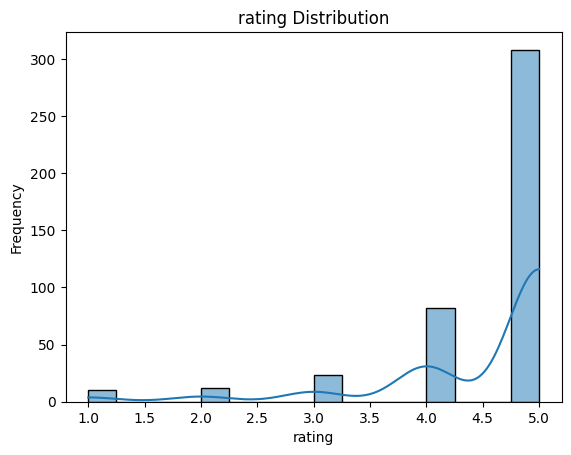

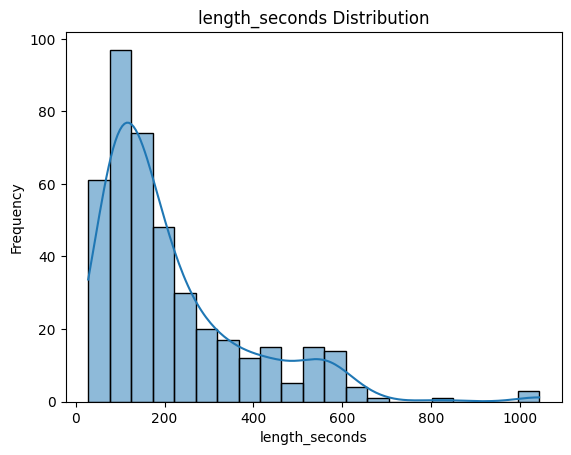

In [ ]:
check_multimodality(snippets, ['rating', 'length_seconds'])

In [ ]:
check_skewness_and_kurtosis(snippets, ['rating', 'length_seconds'])

Column 'rating': Skewness = -2.27, Kurtosis = 5.03
Column 'length_seconds': Skewness = 1.76, Kurtosis = 3.89


In [ ]:
remove_duplicates(snippets)

Removed 0 duplicate rows


,description,rating,length_seconds,created_at
0,Accepting criticism and being open to listen t...,5,123.0,2022-07-27 22:18:54.790133
1,Accept the regularities of life instead of bei...,5,123.0,2022-08-28 16:47:23.626192
2,"Acknowledge the pain, but still showing gratitude",5,118.0,2022-07-11 03:08:02.677464
3,A deep dive into shame.\r\n,5,571.0,2022-04-02 13:31:36.037417
4,A different take on the glass half empty saying.,5,492.0,2022-03-09 10:09:34.3905
...,...,...,...,...
430,Why it's important to face your fears,5,281.0,2022-04-05 04:57:56.376683
431,Work hard enough to get the tools needed to su...,5,92.0,2022-02-01 16:08:00.739895
432,Working together to commit and learn through t...,5,288.0,2022-05-09 13:34:45.529048
433,Writing down what you want accomplished within...,5,233.0,2022-07-26 01:18:58.521865


## Fixing Issues

### Engagement

In [ ]:
engagement = impute_missing_values(engagement, ["age","gender","primary_problem","last_ahoy_visit","days_engaged","elapsed_days"])

In [ ]:
check_missing_values(engagement)

user_id                   0
user_created_at           0
bought_hero               0
intake                    0
wol                       0
daily_assessment          0
started_lesson            0
upload_worksheet          0
rated_lesson_1            0
finished_module_1         0
created_community_acct    0
completed_lesson          0
age                       0
gender                    0
primary_problem           0
last_ahoy_visit           0
days_engaged              0
elapsed_days              0
dtype: int64


In [ ]:
engagement.head()

,user_id,user_created_at,bought_hero,intake,wol,daily_assessment,started_lesson,upload_worksheet,rated_lesson_1,finished_module_1,created_community_acct,completed_lesson,age,gender,primary_problem,last_ahoy_visit,days_engaged,elapsed_days
0,1773,2022-02-19,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,42.0000,Male,Alcohol,2022-10-01,22.0,224.0
1,1674,2022-02-07,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0000,Male,Alcohol,2022-02-07,1.0,0.0
2,1641,2022-02-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0000,Male,Alcohol,2022-02-04,1.0,0.0
3,1711,2022-02-12,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,38.0000,Female,Drugs,2022-02-15,3.0,3.0
4,2961,2023-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.5774,Female,Drugs,2023-03-30,3.0,1.0


### Snippets

In [ ]:
snippets = impute_missing_values(snippets, ["length_seconds"])

In [ ]:
check_missing_values(snippets)

description       0
rating            0
length_seconds    0
created_at        0
dtype: int64


In [ ]:
engagement.shape

(1557, 18)

## Feature Selection

In [ ]:
engagement.dtypes

user_id                     int64
user_created_at            object
bought_hero               float64
intake                    float64
wol                       float64
daily_assessment          float64
started_lesson            float64
upload_worksheet          float64
rated_lesson_1            float64
finished_module_1         float64
created_community_acct    float64
completed_lesson          float64
age                       float64
gender                     object
primary_problem            object
last_ahoy_visit            object
days_engaged              float64
elapsed_days              float64
dtype: object

In [ ]:
engagement.head()

,user_id,user_created_at,bought_hero,intake,wol,daily_assessment,started_lesson,upload_worksheet,rated_lesson_1,finished_module_1,created_community_acct,completed_lesson,age,gender,primary_problem,last_ahoy_visit,days_engaged,elapsed_days
0,1773,2022-02-19,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,42.0000,Male,Alcohol,2022-10-01,22.0,224.0
1,1674,2022-02-07,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0000,Male,Alcohol,2022-02-07,1.0,0.0
2,1641,2022-02-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0000,Male,Alcohol,2022-02-04,1.0,0.0
3,1711,2022-02-12,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,38.0000,Female,Drugs,2022-02-15,3.0,3.0
4,2961,2023-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.5774,Female,Drugs,2023-03-30,3.0,1.0


In [ ]:
# Convert the non-integer columns to binary columns using one-hot encoding
engagement = pd.get_dummies(engagement, columns=['gender'])
engagement = pd.get_dummies(engagement, columns=['primary_problem'])
engagement = engagement.drop(columns = ['user_created_at', 'user_id', 'last_ahoy_visit'])

In [ ]:
engagement.head()

,bought_hero,intake,wol,daily_assessment,started_lesson,upload_worksheet,rated_lesson_1,finished_module_1,created_community_acct,completed_lesson,...,gender_Female,gender_Male,primary_problem_Alcohol,primary_problem_Cannabis,primary_problem_Drugs,primary_problem_Food,primary_problem_Gambling,primary_problem_Nicotine,primary_problem_Other,primary_problem_Sex
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,1,0,0,0,0,0,0,0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,0,0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,0,0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,1,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0


In [ ]:
engagement.dtypes

bought_hero                 float64
intake                      float64
wol                         float64
daily_assessment            float64
started_lesson              float64
upload_worksheet            float64
rated_lesson_1              float64
finished_module_1           float64
created_community_acct      float64
completed_lesson            float64
age                         float64
days_engaged                float64
elapsed_days                float64
gender_Female                 uint8
gender_Male                   uint8
primary_problem_Alcohol       uint8
primary_problem_Cannabis      uint8
primary_problem_Drugs         uint8
primary_problem_Food          uint8
primary_problem_Gambling      uint8
primary_problem_Nicotine      uint8
primary_problem_Other         uint8
primary_problem_Sex           uint8
dtype: object

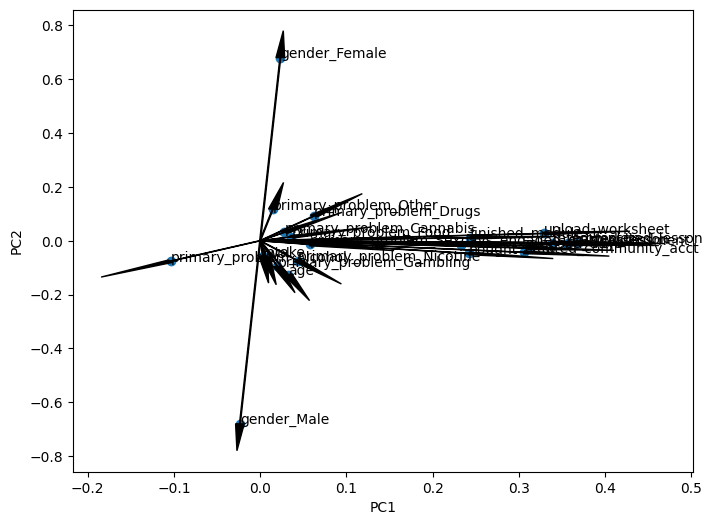

In [ ]:
pca_eng, comp_eng = pca_df(engagement, 7)

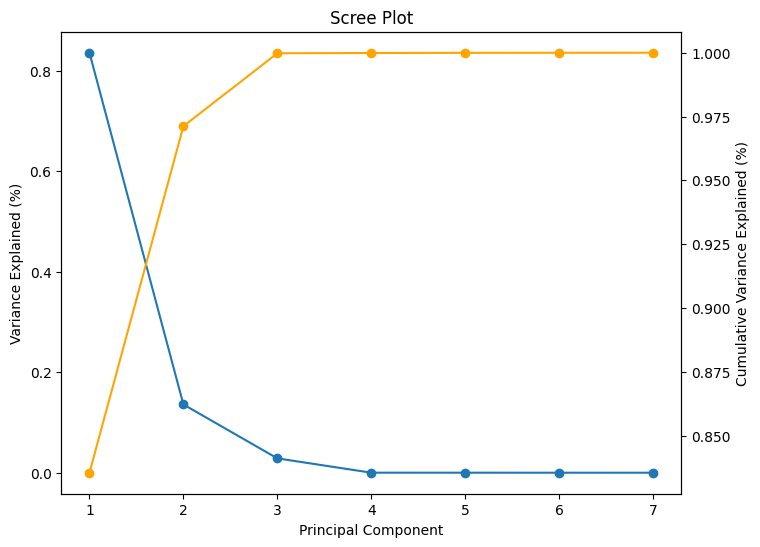

In [ ]:
scree_plot(comp_eng)

In [ ]:
comp_eng

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,198.955434,-38.148614,-1.358616,0.743693,-0.494908,-0.780239,0.900403
1,-22.919645,-0.548034,-5.305639,0.825962,0.213350,-0.124318,0.057097
2,-22.839859,-0.460233,1.693194,0.791039,0.219763,-0.096206,0.051573
3,-19.471380,0.635973,-3.368412,-0.678996,-1.336156,0.891108,-0.064368
4,-21.372325,1.195322,0.222164,-0.635294,-0.047262,1.087350,0.428995
...,...,...,...,...,...,...,...
1552,-22.999431,-0.635834,-12.304473,0.860885,0.206938,-0.152429,0.062621
1553,-22.839553,-0.459406,1.685865,-0.618491,0.309256,-0.068345,0.006937
1554,-12.393494,-0.137060,2.562782,-0.615731,0.386611,-0.045075,0.019953
1555,-14.938653,-1.663150,-6.387381,0.804780,-0.808071,1.106403,-0.316476


In [ ]:
engagement_FI, importances = feature_importance_df(engagement, "days_engaged")

In [ ]:
engagement.dtypes

bought_hero                 float64
intake                      float64
wol                         float64
daily_assessment            float64
started_lesson              float64
upload_worksheet            float64
rated_lesson_1              float64
finished_module_1           float64
created_community_acct      float64
completed_lesson            float64
age                         float64
days_engaged                float64
elapsed_days                float64
gender_Female                 uint8
gender_Male                   uint8
primary_problem_Alcohol       uint8
primary_problem_Cannabis      uint8
primary_problem_Drugs         uint8
primary_problem_Food          uint8
primary_problem_Gambling      uint8
primary_problem_Nicotine      uint8
primary_problem_Other         uint8
primary_problem_Sex           uint8
dtype: object

In [ ]:
importances

array([2.38125597e-02, 2.13184165e-07, 5.38112785e-05, 1.04894165e-03,
       5.29781543e-03, 1.66848471e-02, 1.93049487e-02, 2.23982903e-02,
       4.71423603e-02, 3.84728506e-02, 1.25286200e-01, 6.45636616e-01,
       1.62908489e-02, 5.39486638e-03, 8.31509063e-03, 1.73049927e-02,
       9.49765819e-04, 4.95769793e-04, 2.06237922e-03, 3.22725635e-03,
       6.38847550e-04, 1.80728953e-04])

In [ ]:
engagement_FI.dtypes

elapsed_days                float64
age                         float64
created_community_acct      float64
completed_lesson            float64
bought_hero                 float64
finished_module_1           float64
rated_lesson_1              float64
primary_problem_Cannabis      uint8
upload_worksheet            float64
gender_Female                 uint8
primary_problem_Alcohol       uint8
gender_Male                   uint8
started_lesson              float64
primary_problem_Nicotine      uint8
primary_problem_Gambling      uint8
daily_assessment            float64
primary_problem_Drugs         uint8
primary_problem_Other         uint8
primary_problem_Food          uint8
primary_problem_Sex           uint8
wol                         float64
intake                      float64
days_engaged                float64
dtype: object

In [ ]:
engagement_df = engagement_FI.drop(columns = ['wol','intake'])

In [ ]:
engagement_df.dtypes

elapsed_days                float64
age                         float64
created_community_acct      float64
completed_lesson            float64
bought_hero                 float64
finished_module_1           float64
rated_lesson_1              float64
primary_problem_Cannabis      uint8
upload_worksheet            float64
gender_Female                 uint8
primary_problem_Alcohol       uint8
gender_Male                   uint8
started_lesson              float64
primary_problem_Nicotine      uint8
primary_problem_Gambling      uint8
daily_assessment            float64
primary_problem_Drugs         uint8
primary_problem_Other         uint8
primary_problem_Food          uint8
primary_problem_Sex           uint8
days_engaged                float64
dtype: object

## Regression Models

In [ ]:
linear_regression(engagement_df, "days_engaged")

Linear Regressor (Train) Mean Squared Error: 765.26
Linear Regressor (Train) Mean Absolute Error: 6.03
Linear Regressor (Train) R-Squared Value: 0.23
Linear Regressor (Train) Adjusted R-Squared Value: 0.22 

Linear Regressor (Test) Mean Squared Error: 198.23
Linear Regressor (Test) Mean Absolute Error: 5.74
Linear Regressor (Test) R-Squared Value: 0.57
Linear Regressor (Test) Adjusted R-Squared Value: 0.54 



In [ ]:
gradient_boosting_regression(engagement_df, "days_engaged")

Gradient Boosting Regressor Mean Squared Error: 239.94
Gradient Boosting Regressor Mean Absolute Error: 4.60
Gradient Boosting Regressor R-Squared Value: 0.48
Gradient Boosting Regressor Adjusted R-Squared Value: 0.44 



In [ ]:
xgboost_regression(engagement_df, "days_engaged")

XGBoost Regressor Mean Squared Error: 264.78
XGBoost Regressor Mean Absolute Error: 4.96
XGBoost Regressor R-Squared Value: 0.42
XGBoost Regressor Adjusted R-Squared Value: 0.39 



In [ ]:
support_vector_regression(engagement_df, "days_engaged")

Support Vector Regressor Mean Squared Error: 246.13
Support Vector Regressor Mean Absolute Error: 4.61
Support Vector Regressor R-Squared Value: 0.47
Support Vector Regressor Adjusted R-Squared Value: 0.43 

